## Imports

In [ ]:
import scipy.io
import numpy as np
import math
from sklearn import linear_model
from scipy import linalg
from sklearn import preprocessing as preproc  # load preprocessing function
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.model_selection import KFold

# seaborn can be used to "prettify" default matplotlib plots by importing and setting as default
import seaborn as sns

sns.set()  # Set searborn as default

## Load dataset

In [ ]:
mat = scipy.io.loadmat("sand.mat")

X = mat["X"]
y = mat["Y"]

[n, p] = X.shape
print("Number of observations: ", n)
print("Number of features: ", p)

Number of observations:  59
Number of features:  2016


### 1 Apply Least angle regression and selection (LARS) for the p >> n sand data set (X: data matrix with 59 observations and 2016 features, y: the measured moisture content in percent for each sand sample). Find a suitable solution using:

>(a) The Cp statistic. Consider whether the Cp-statistic makes sense in this case (p > n). Why? Why not?

>> (i) Hint: What happens to your estimate of the noise in the data?

When you calculate the $ \sigma^2 $ to get the estimate of the noise in the data you can already see that the value is really small. This mean that when p > n the “full” model is saturated—it fits the data perfectly (or nearly so), giving an (artificially) zero residual sum of squares and hence a noise estimate that is essentially zero. This, in turn, leads to a misleadingly low $C_p$ value that does not properly penalize model complexity. While LARS can be applied in high-dimensional contexts, using the $C_p$ criterion to select among models is generally not advisable in these cases.

In [7]:
# Estimate the noise of the data
# Calculate an unbiased OLS estimate using linalg.lstsq
betas, residuals, rank, s = linalg.lstsq(X, y)
y_hat = np.dot(X, betas)
sigma2 = np.mean((y - y_hat) ** 2)
print("Estimated noise: ", sigma2)

Estimated noise:  1.1142327243211658e-24


>(b) Using Cross-validation. Remember to center y and normalize X, but do it inside
the cross validation!

In [ ]:
def centerData(data):

    mu = np.mean(data, axis=0)
    data = data - mu

    return data, mu


# Set up cross validation like you did last week
CV = 5  # if K = n leave-one-out, you may try different numbers
kf = KFold(n_splits=CV)

# Set a suitable range of features that can be given to LARS as n_nonzero_coefs
stop = n - math.ceil(n / CV)
K = range(1, stop)

Err_tr = np.zeros((CV, len(K)))
Err_tst = np.zeros((CV, len(K)))
for i, (train_index, test_index) in enumerate(kf.split(X)):
    # NOTE: If you normalize outside the CV loop the data implicitly carry information of the test data
    # We should perform CV "the right way" and keep test data unseen.
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Center y
    y_train, mu = centerData(y_train)
    y_test = y_test - mu

    # Normalize the data
    X_train = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
    X_test = (X_test - np.mean(X_test, axis=0)) / np.std(X_test, axis=0)
    # compute all LARS solutions inside each fold
    for k in K:
        # Predict with this model, and find both training and test error
        reg = linear_model.Lars(
            n_nonzero_coefs=k + 1, fit_path=False, fit_intercept=False, verbose=True
        )
        reg.fit(X_train, y_train)
        beta = reg.coef_.ravel()

        # Compute errors
        y_train_est = X_train @ beta
        y_test_est = X_test @ beta

        Err_tr[i, k - 1] = np.mean((y_train - y_train_est) ** 2)
        Err_tst[i, k - 1] = np.mean((y_test - y_test_est) ** 2)


err_tr = np.mean(Err_tr, axis=0)  # mean training error over the CV folds
err_tst = np.mean(Err_tst, axis=0)  # mean test error over the CV folds
err_ste = np.std(Err_tst, axis=0) / np.sqrt(CV)
# Note: we divide with sqrt(n) to get the standard error as opposed to the standard deviation
print("Mean training error: ", err_tr)
print("Mean test error: ", err_tst)
print("Standard error: ", err_ste)

Mean training error:  [  4.51663225   4.68660869   4.86375964   4.98201353   5.36716677
   5.38452334   5.47205199   5.48932355   5.5203982    5.63455319
   6.04650766   6.19918809   6.23202169   6.45772787   6.71327283
   7.0234129    8.25818194   8.36679697   9.0552589   10.49470775
  11.30500024  14.24249749  15.67609851  18.75780606  19.29530355
  21.59563657  23.47314151  25.79700877  27.53890802  29.24897205
  30.58578542  34.52672586  36.25917092  41.50762625  49.38655624
  51.3309707   52.42311333  57.83480992  66.07920202  72.95307776
  77.80941352  85.70455244  95.95942098 104.03724009 115.89172793
 125.09602833]
Mean test error:  [5.45556169e+00 5.58761405e+00 5.74706569e+00 5.86684672e+00
 6.19364381e+00 6.19676859e+00 6.26182298e+00 6.28964329e+00
 6.36306212e+00 6.92659345e+00 9.92439005e+00 1.07241096e+01
 1.08893787e+01 1.29214835e+01 1.52185003e+01 1.97641809e+01
 5.16075148e+01 5.32175526e+01 6.69693443e+01 1.04733306e+02
 1.34089941e+02 3.16487882e+02 3.73967503e+02 

In [12]:
# Compute Cp-statistic, assumption n > p
X_norm, _ = centerData(X)
X_norm = X_norm / np.std(X_norm, axis=0)

# run LARS on all data and and vary the nonzero coefs from 0 to p. save the betas for Cp
Betas = np.zeros((p, n))
for j in range(1, n):
    reg = linear_model.Lars(n_nonzero_coefs=j)
    reg.fit(X_norm, y)
    Betas[:, i] = reg.coef_

# calculate Cp for each number of nonzero coefs
Cp = np.zeros((len(K)))
for j in range(len(K)):
    Yhat = X_norm @ Betas[:, K[j]]
    Cp[j] = np.mean(((y - Yhat) ** 2)) + 2 * K[j] / n * sigma2

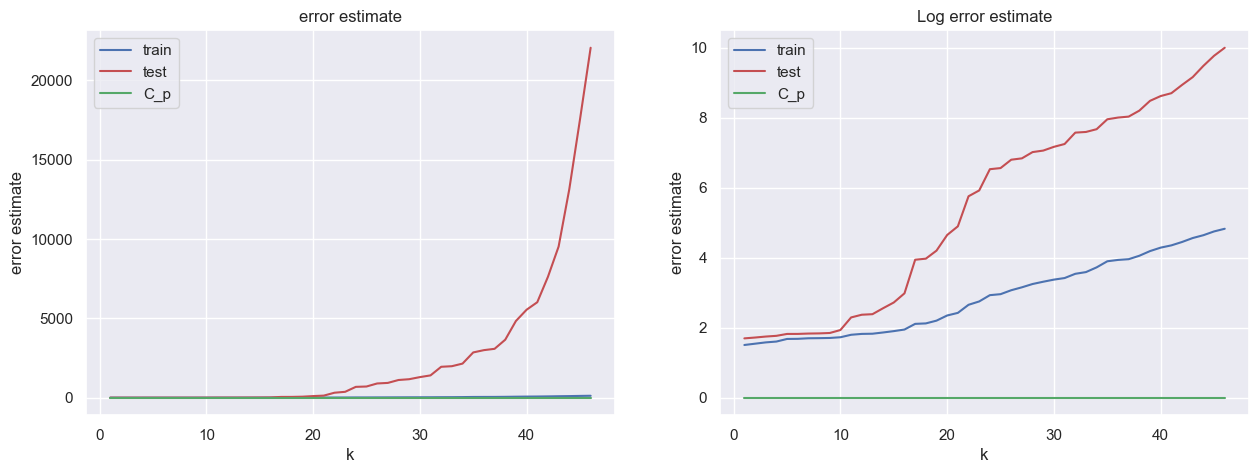

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(K, err_tr, "b", label="train")
ax[0].plot(K, err_tst, "r", label="test")
ax[0].plot(K, Cp / 1e27, "g", label="C_p")  # scale to put in same plot
ax[0].legend()
ax[0].set_xlabel("k")
ax[0].set_ylabel("error estimate")
ax[0].set_title("error estimate")

ax[1].plot(K, np.log(err_tr), "b", label="train")
ax[1].plot(K, np.log(err_tst), "r", label="test")
ax[1].plot(K, Cp / 1e27, "g", label="C_p")  # scale to put in same plot
ax[1].legend()
ax[1].set_xlabel("k")
ax[1].set_ylabel("error estimate")
ax[1].set_title("Log error estimate")
plt.show()